In [1]:
import numpy as np, xarray as xr, datashader as ds, colorcet as cc
import matplotlib.pyplot as plt
from numba import jit 
from datashader.utils import export_image
from colorcet import palette
from datashader import transfer_functions as tf

CPU times: user 4 s, sys: 70 ms, total: 4.07 s
Wall time: 4.1 s


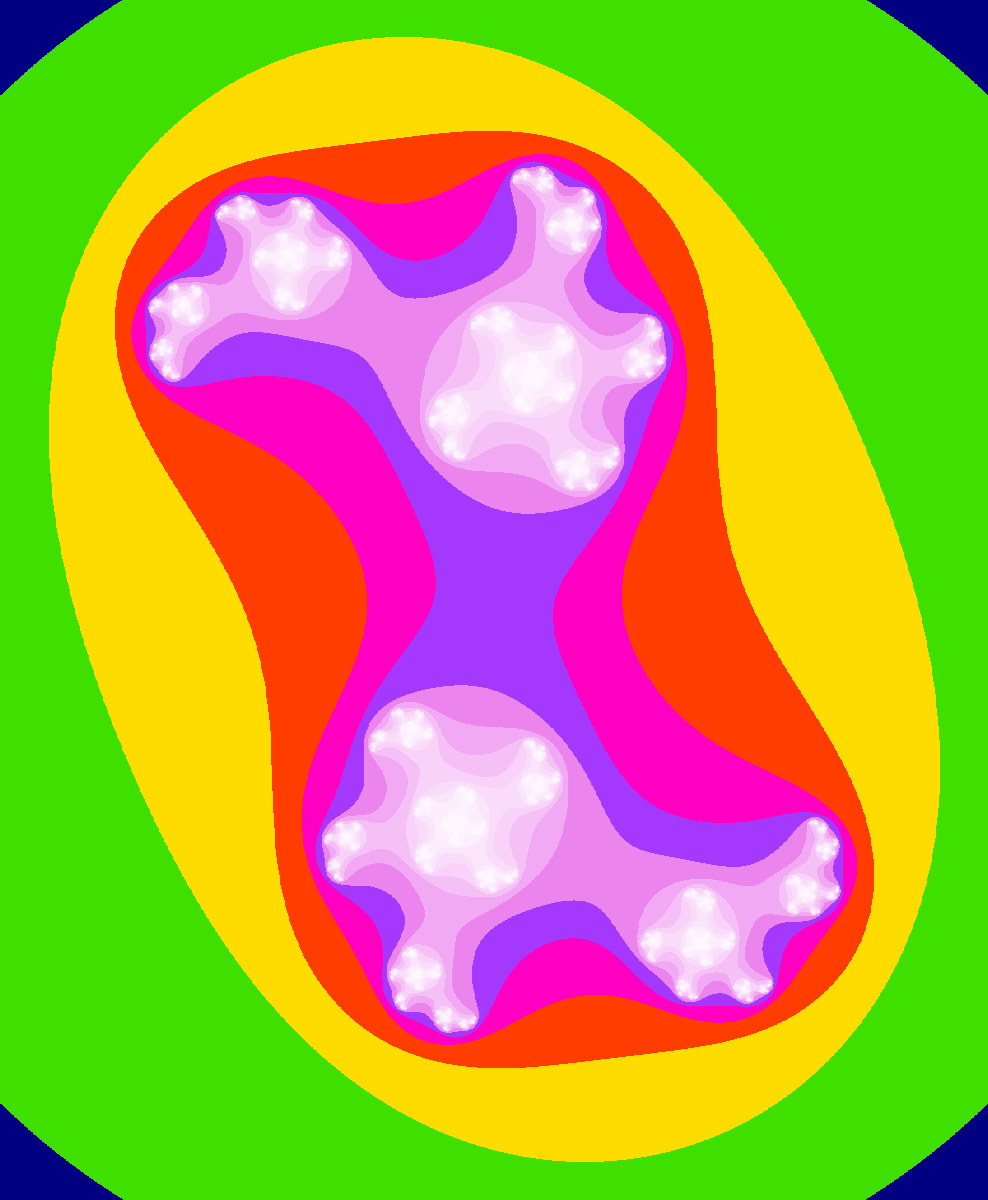

In [2]:
@jit(nopython=True)
def julia_iter(c, NPOINTS, h_range, v_range):
    h_points = np.arange(*h_range, (h_range[1] - h_range[0]) / NPOINTS)
    v_points = np.arange(*v_range, (v_range[1] - v_range[0]) / NPOINTS)
    z = np.array([complex(h,v) for v in v_points for h in h_points]) # coords in the canvas
    color = np.zeros(len(z))
    itera = 1000
    for _ in range(itera):
        i=0
        norma = np.absolute(z) < 2 
        for n in norma:
            if n:
                z[i] = z[i] ** 2 + c
                color[i] += 1
            i += 1
    color[norma]=0
    return color.reshape(NPOINTS,NPOINTS), h_points, v_points
  
#@jit#(nopython=True)
def julia(fractal=julia_iter, **op):
    op_default = {"cmap":cc.rainbow, "NPOINTS":1200, "h_range":(-1.4,1.4), "v_range":(-1.7,1.7), "save":False}
    if op: op_default.update(op)
    op = op_default
    color, xs, ys = fractal(op["c"], op["NPOINTS"], op["h_range"], op["v_range"])
    h, v, scale = op["h_range"], op["v_range"], op["NPOINTS"]
    dim = int(scale*(h[1]-h[0])/(v[1]-v[0])), int(scale)
    res = tf.shade(ds.Canvas(*dim, x_range=h, y_range=v).raster(xr.DataArray(color, coords=[('y',ys), ('x',xs)])), cmap=op['cmap'])
    #res = tf.shade(xr.DataArray(color, coords=[('y',ys), ('x',xs)]), cmap=op['cmap'])
    if op["save"]: # save to op["save"] filename
        return export_image(img=res, filename=op["save"], fmt=".png", export_path="./")
    return res


#%time julia(c=1j, NPOINTS=1200, cmap=plt.cm.gist_ncar, save="julia0")
#%time julia(c=.5j, NPOINTS=1200, cmap=plt.colormaps['gist_ncar'], save="julia1")
#%time julia(c=1+1j, NPOINTS=1200, cmap=plt.colormaps['gist_ncar'], save="julia2")
%time julia(c=.5+.5j, NPOINTS=1200, cmap=plt.colormaps['gist_ncar'], save="julia3")

CPU times: user 4.82 s, sys: 70.2 ms, total: 4.89 s
Wall time: 4.89 s


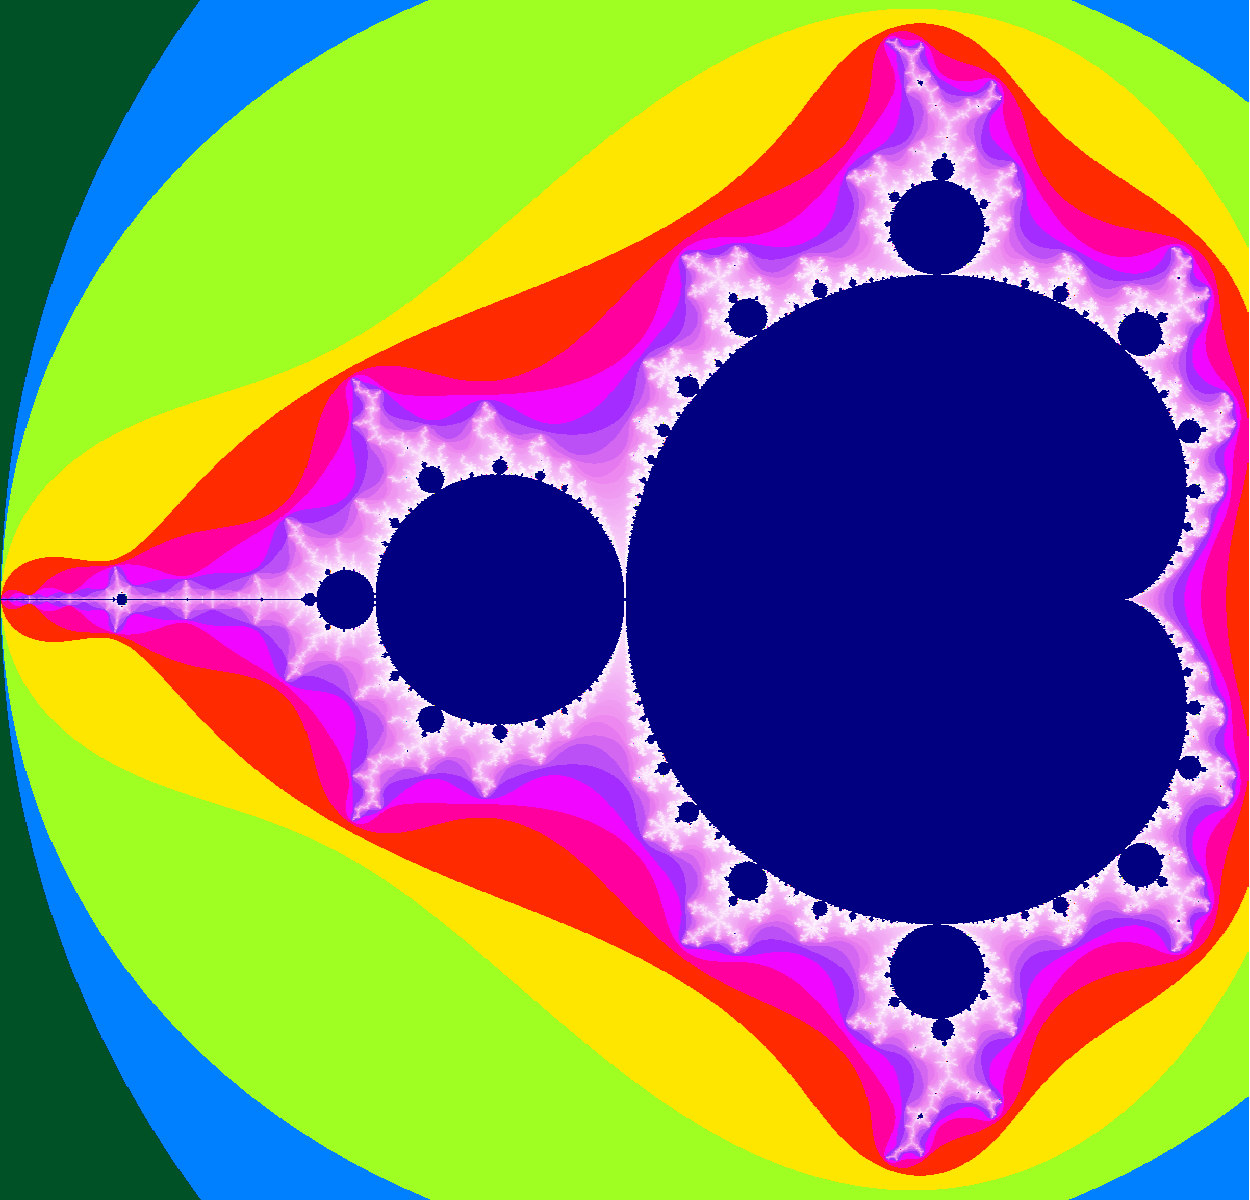

In [3]:
@jit(nopython=True)
def mandel_iter(c, NPOINTS, h_range, v_range):
    h_points = np.arange(*h_range, (h_range[1] - h_range[0]) / NPOINTS)
    v_points = np.arange(*v_range, (v_range[1] - v_range[0]) / NPOINTS)
    c = np.array([complex(h,v) for v in v_points for h in h_points]) # coords in the canvas
    z = np.zeros_like(c) # complex zeros
    color = np.zeros(len(z)) # real zeros (a numba thing)
    itera = 1000
    for _ in range(itera):
        i=0
        norma = np.absolute(z) < 2 
        for n in norma:
            if n:
                z[i] = z[i] ** 2 + c[i]
                color[i] += 1
            i += 1
    color[norma]=0
    return color.reshape(NPOINTS,NPOINTS), h_points, v_points
  
"""
def mandelbrot(fractal=mf, **op):
    op_default = {"cmap":viridis, "NPOINTS":100, "h_range":(-2,.5), "v_range":(-1.25,1.25)}
    if op: op_default.update(op)
    op = op_default
    color, xs, ys = fractal(op["NPOINTS"], op["h_range"], op["v_range"])
    da = xr.DataArray(color, coords=[('y',xs), ('x',xs)])
    return tf.shade(da, cmap=op['cmap'])
"""
def mandelbrot(**op):
    opd = {"h_range":(-2,.5), "v_range":(-1.2,1.2), "c":None}
    if op: opd.update(op)
    op = opd
    res = julia(fractal=mandel_iter, **op)
    if op["save"]: # save to op["save"] filename
        return export_image(img=res, filename=op["save"], fmt=".png", export_path="./")
    return res

%time mandelbrot(cmap=plt.colormaps['gist_ncar'], NPOINTS=1200, save="julia4")
#export_image(img=m1, filename="m1", fmt=".png", export_path="./")

In [4]:
%time mandelbrot(cmap=plt.colormaps['gist_ncar'], h_range=(-.12, -.1), v_range=(.7, .8))

/Users/felipecontreras/anaconda3/lib/python3.9/site-packages/datashader/transfer_functions/__init__.py:314: RuntimeWarning: invalid value encountered in true_divide
  scaled_data = (data - span[0])/(span[1] - span[0])


KeyError: 'save'